# Inaugural Project - Housing demand and taxation
### - *Mathilde Pilgaard, Klara Krogh Hammerum, Louise Albæk Jensen og Oluf Kelkjær*
A given household can spend cash $m$ on either housing or consumption $c$. Quality of housing, $h$, grants household utility and has the cost $p_{h}$ which is subject to progressive taxation and morgage cost as by equation (\ref{eq4}). The household aims to maximize utility such that optimal amounts of housing, $h^{*}$, and consumption, $c^{*}$, are met according to equation (\ref{eq1}).

\begin{align}
    c^{*},h^{*} & = \underset{c, h}{\operatorname{argmax}} c^{1-\phi}h^{\phi} \label{eq1}\tag{1} \\
    &s.t.\\
    \tilde{p}_{h} &= p_{h}\varepsilon \label{eq2}\tag{2} \\
    m &= \tau(p_{h},\tilde{p}_{h})+c \label{eq3}\tag{3} \\
    \tau(p_{h},\tilde{p}_{h})&=r p_{h}+\tau^{g}\tilde{p}_{h}+\tau^{p}max\{\tilde{p}_{h}-\bar{p},0\} \label{eq4}\tag{4}
\end{align}

The homes are taxed according to the public assesment being $\tilde{p}_{h}$. The assesment is politically decided according to equation (\ref{eq2}) by $\varepsilon$. Available cash for a given household is split between housing costs and consumption. $r$ denotes the carrying interest for purchasing a home, and $\tau^{g}$ denotes the base housing tax while the last element in equation (\ref{eq4}) homes valued above a certain cutoff, $\bar{p}$ are taxed at an additional rate $\tau^{p}$

*

# Q1
Construct a function that solves household's problem above. We let the market price of a home be equal to its quality:
$$ p_{h}=h $$
and assume that the household in question has cash-on-hand $m=0.5$. Notive that the monetary units is in millions DKK. In addition use the given parameter-values.
Knowing that the marketprice of a home is equal to its quality, we can use a scalar solver using the problems monotonicity.
$$ c = m - \tau(p_{h},\tilde{p}_{h})\Leftrightarrow $$
$$ c = m - rh-\tau^{g}h\varepsilon+\tau^{p}max\{h\varepsilon-\bar{p},0 \}   $$
meaning $c$ is implicit for a given level of $h$ through the budget constraint

In [1]:
# Importing relevant packages
from scipy import optimize
import numpy as np

par1 = {'m':0.5,
        'phi':0.3,
        'epsilon': 0.5,
        'r': 0.03,
        'tau_g': 0.012,
        'tau_p': 0.004,
        'p_bar': 3
}


# Creating utility function
def u_func(c, h, phi):
    return c**(1-phi)*h**phi

# Creating objective function to minimize
def value_of_choice(h,m,phi,epsilon,r,tau_g, tau_p, p_bar):
    c = m - r*h-tau_g*h*epsilon-tau_p*max(h*epsilon-p_bar,0)
    return -u_func(c,h,phi)


In [2]:
from scipy import optimize


def u_optimizer(phi, m, epsilon, r, tau_g, tau_p, p_bar, print_res = False, **kwargs):
    sol = optimize.minimize_scalar(lambda h: value_of_choice(h,phi, m, epsilon, r, tau_g, tau_p, p_bar),
                                  method = 'bounded', bounds = (0,m*10))
    h = sol.x
    h_cost = r*h+tau_g*h*epsilon+tau_p*max(h*epsilon-p_bar,0) 
    c = m - h_cost
    u = u_func(c,h,phi)
    
    
    if print_res == True:
        excess_dkk = m - h_cost - c
        
        text = f'---'*35
        text += '\nFor parameters:\n'
        text += f'\u03C6={phi:.3f}'
        text += f' m={m:.3f}'
        text += f' \u03B5={epsilon:.3f}'
        text += f' r={r:.3f}'
        text += f' \u03C4ᵍ={tau_g:.3f}'
        text += f' \u03C4ᵖ={tau_p:.3f}'
    
        text += f'\nThe optimal allocation of ressources is consuming c={c:.3f} while buying a house of quality h={h:.3f} \n'
        text += f'As the household pays no downpayment and only has to service interest-rate and housing taxes, the total spending amounts to:\n'
        text += f'c={c:.3f} and buying a house of quality h={h:.3f} at a cost of {h_cost:.3f} leaving excess mDKK of {excess_dkk:.3f}\n\n'
        text += f'Above allocation of ressources results in a utility of {u:.3f}\n'
        text += f'---'*35
        print(text)
    
    
    return u, h, c

u_star, h_star, c_star = u_optimizer(**par1, print_res = True)



---------------------------------------------------------------------------------------------------------
For parameters:
φ=0.300 m=0.500 ε=0.500 r=0.030 τᵍ=0.012 τᵖ=0.004
The optimal allocation of ressources is consuming c=0.350 while buying a house of quality h=4.167 
As the household pays no downpayment and only has to service interest-rate and housing taxes, the total spending amounts to:
c=0.350 and buying a house of quality h=4.167 at a cost of 0.150 leaving excess mDKK of 0.000

Above allocation of ressources results in a utility of 0.736
---------------------------------------------------------------------------------------------------------


In [5]:
import numpy as np
N = 10000

# Initializing storage
m_array = np.linspace(0.4,4,N)
h_stars = np.empty(N)
c_stars = np.empty(N) 
u_stars = np.empty(N)

# Excluding m in a new dictionary, such that it can be varied.
par1_exc = par1.copy()
del par1_exc['m']
par1_exc

for i, v in enumerate(m_array):
    result_vector = u_optimizer(**par1_exc, m=v, print_res = False)
    
    # loading results
    u_stars[i] = result_vector[0]
    h_stars[i] = result_vector[1]
    c_stars[i] = result_vector[2]
    
# print(u_stars)


# Plot housing costs
# I will probably sky-rocket or at least kink at some point.
# Problem: c can be negative, shouldn't happen
# Create bounds on h, such that cost of h can't exceed some limit.
# Perhaps make the unknown h, such that c is selected and put boundary on such that c can't exceed m.

c_stars

array([0.28000003, 0.28025206, 0.28050408, ..., 3.43079611, 3.43110389,
       2.76400002])

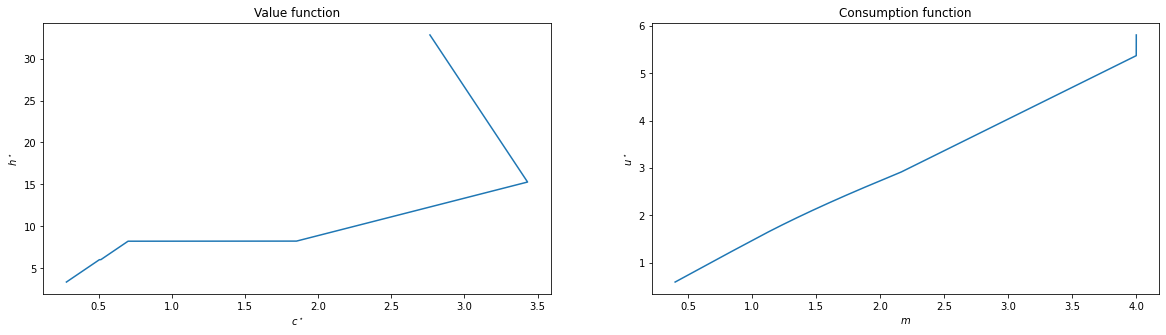

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,5))# figsize is in inches

ax = fig.add_subplot(1,2,1)
ax.plot(c_stars,h_stars)
ax.set_xlabel(f"$c^\star$")
ax.set_ylabel(f"$h^\star$")
ax.set_title(f'Value function')

ax_right = fig.add_subplot(1,2,2)
ax_right.plot(m_array,u_stars)
ax_right.set_xlabel(f"$m$")
ax_right.set_ylabel(f"$u^\star$")
ax_right.set_title(f'Consumption function')


plt.show()

In [7]:
par1_exc = par1.copy()
del par1_exc['m']
par1_exc
u_star, h_star, c_star = u_optimizer(**par1_exc, m=2)
u_star

2.7266258104263303